# Feature engineering + Radek's Notebook

This file is based on this [https://github.com/radekosmulski/personalized_fashion_recs/tree/main] repository. In addition to already prepared data, I engineered some features which slightly improved the predictions. Check at Feature Engineering part.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm.sklearn import LGBMRanker

In [2]:
%%time

# transactions = pd.read_parquet('../input/warmup/transactions_train.parquet')
# customers = pd.read_parquet('../input/warmup/customers.parquet')
# articles = pd.read_parquet('../input/warmup/articles.parquet')

# Read compressed data
transactions = pd.read_pickle('../../data/compressed_data/transactions_train.pkl')
customers = pd.read_pickle('../../data/compressed_data/customers.pkl')
articles = pd.read_pickle('../../data/compressed_data/articles.pkl')

# Calculate week, where 0 is first week of data and 104 is last week of data
transactions['week'] = 104 - (transactions.t_dat.max() - transactions.t_dat).dt.days // 7

print('First week num: ', transactions.week.min(), '\nLast week num: ', transactions.week.max(), '\n')

First week num:  0 
Last week num:  104 

CPU times: user 403 ms, sys: 282 ms, total: 686 ms
Wall time: 688 ms


In [3]:
# Test week is week after last week in train data
test_week = transactions.week.max() + 1

# Filter transactions to last 15 weeks (most recent data)
transactions = transactions[transactions.week > transactions.week.max() - 10]

# Generating candidates
### Last purchase candidates

In [4]:
transactions.sample(3)

,t_dat,customer_id,article_id,price,sales_channel_id,week
30848793,2020-08-28,470268,923037002,0.033875,2,101
29939810,2020-08-05,146488,856816001,0.049011,2,98
31726748,2020-09-21,141788,926340001,0.059296,2,104


In [5]:
# Calculate weeks in which a customer has made a purchase
c2weeks = transactions.groupby('customer_id')['week'].unique()
c2weeks.sample(2)

customer_id
341404         [95]
1310107    [97, 98]
Name: week, dtype: object

In [6]:
# Move weeks by one, so we have artificial test week data
# Mapping: {customer_id: {week: shifted_week}}
c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}

    # If customer has more than one week - shift all weeks by one
    for i in range(weeks.shape[0] - 1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]

    # If customer has only one week - shif it to test week
    # Test week is week 105 (see earlier)
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

In [7]:
# For each customer - week pair, replace week with shifted week
candidates_last_purchase = transactions.copy()

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week = weeks

# # This is second way to do that (slower but more readable)
# candidates_last_purchase = transactions.copy()
# candidates_last_purchase['week'] = candidates_last_purchase.apply(lambda x: c2weeks2shifted_weeks[x.customer_id][x.week], axis=1)

In [8]:
candidates_last_purchase.sample(3)

,t_dat,customer_id,article_id,price,sales_channel_id,week
30121199,2020-08-09,245957,739590032,0.016937,1,105
29049663,2020-07-15,648608,872527002,0.016937,1,100
31523920,2020-09-15,103727,911981001,0.086426,2,104


### Bestsellers candidates

In [9]:
# Average price of each article in each week
mean_price = transactions \
    .groupby(['week', 'article_id'])['price'].mean()

# First count how many times each article was purchased in each week
# Then rank articles by the number of purchases in each week
# Then select top 12 articles for each week and rename the column

# Result is pairs (week, article_id) with rank of the article in that week (base on number of total purchases)
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

# 12 articles per week
assert len(sales) == 12 * transactions.week.nunique(), 'Length of sales should be 12 * number of unique weeks'

In [10]:
# Connect sales rank with mean price for specific week and article
bestsellers_previous_week = pd.merge(sales, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1  

In [11]:
# DF of Customers who made a purchase in a given week + sales channel -- repeated customer ids possible
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

# # # second way to get unique transactions (more readable)
# unique_transactions2 = transactions \
#     .drop_duplicates(['week', 'customer_id']) \
#     .drop(columns=['article_id', 'price'])

In [12]:
# DF of customers + bestselling article rank and price -- for each customer purchas in each week
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_week,
    on='week'
)

# Get only unique customers in the period -- for test data we only need each customer once
test_set_transactions = unique_transactions\
    .drop_duplicates('customer_id')\
    .reset_index(drop=True)

test_set_transactions.week = test_week

# DF of customers + bestselling article rank and price -- for each customer purchase in test week
# So after joining 12 rows per customer
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

# Concatenate data with test data
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)


# Combining transactions and candidates / negative examples

In [13]:
# As all data here is historical, we know for fact that all purchases actually occured
assert transactions.week.max() != test_week, 'Test week should not be in historical data'

transactions['purchased'] = 1

In [14]:
display(transactions.sample(3))
display(candidates_last_purchase.sample(3))
display(candidates_bestsellers.sample(3))

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
29563479,2020-07-27,1221709,834217009,0.016937,2,96,1
30690815,2020-08-24,913999,919741001,0.033875,2,100,1
30491301,2020-08-19,110917,752814016,0.033875,2,100,1


,t_dat,customer_id,article_id,price,sales_channel_id,week
29667505,2020-07-30,138707,610776107,0.008461,2,105
29041070,2020-07-15,418510,658030017,0.050842,2,104
29416155,2020-07-24,289393,805000002,0.032104,1,101


,t_dat,customer_id,sales_channel_id,week,article_id,price
3843840,2020-08-19,1281215,2,100,916468003,0.031602
2166318,2020-08-06,132443,1,98,688105002,0.008700
3158512,2020-08-13,808926,2,99,599580072,0.016530


In [15]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
data.purchased.mean()

0.13607582749165664

# Feature Engineering

### Fill missing values in age

Looks like it would be better to fill them with average value rather than median, as histogram looks smoother in such case.

Text(0.5, 1.0, 'Median age')

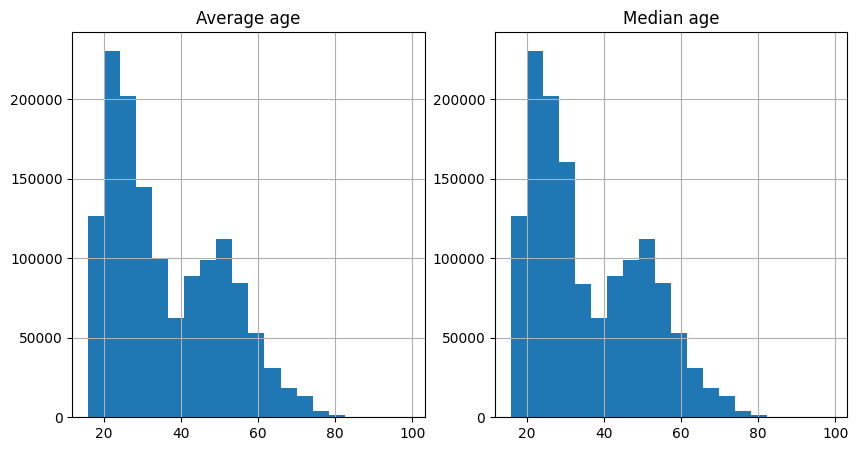

In [16]:
avg_age = customers['age'].astype('float32').mean()
med_age = customers.age.median()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

customers.age.fillna(avg_age).hist(bins=20, ax=ax[0])
ax[0].set_title('Average age')
customers.age.fillna(med_age).hist(bins=20, ax=ax[1])
ax[1].set_title('Median age')

### Most Sold in Last 10 weeks

In [17]:
# Increased the score
# 0.02046 -> 0.02049
bestsellers_last_n_weeks = transactions['article_id'].value_counts()\
    .reset_index()
bestsellers_last_n_weeks['bestseller_rank_n_weeks'] = bestsellers_last_n_weeks['count'].rank(method='dense', ascending=False)
bestsellers_last_n_weeks.drop(columns='count', inplace=True)

### Customers favourite color

In [18]:
# Increased the score
# 0.02049 -> 0.02051
customer_favourite_color = \
    pd.merge(transactions[['customer_id', 'article_id']], articles[['article_id', 'perceived_colour_master_id']], on='article_id')\
    .drop(columns='article_id')\
    .groupby('customer_id')['perceived_colour_master_id'].value_counts()\
    .groupby('customer_id').head(1)\
    .reset_index()\
    .drop(columns='count')\
    .rename(columns={'perceived_colour_master_id': 'fav_perceived_colour_master_id'})   

### Customers favourite channel

In [44]:
customer_favourite_channel = \
    pd.merge(transactions[['customer_id', 'article_id', 'sales_channel_id']], articles[['article_id']], on='article_id')\
    .drop(columns='article_id')\
    .groupby('customer_id')['sales_channel_id'].value_counts()\
    .groupby('customer_id').head(1)\
    .reset_index()\
    .drop(columns='count')\
    .rename(columns={'sales_channel_id': 'fav_sales_channel_id'})

### Bestsellers by postal code

In [20]:
# Lower score
# 0.02051 -> 0.02042
bestsellers_zipcode = \
    pd.merge(transactions[['customer_id', 'article_id']], customers[['customer_id', 'postal_code']], on='customer_id') \
    .drop(columns='customer_id') \
    .groupby('article_id')['postal_code'].value_counts() \
    .groupby('article_id').head(1) \
    .reset_index() \
    .drop(columns='count') \
    .rename(columns={'postal_code': 'most_popular_postal_code'})

### min, avg and max product price

In [21]:
# Increased the score
# 0.02042 -> 0.02094
article_prices = transactions[['article_id', 'price']].groupby('article_id').agg(['min', 'max', 'mean']).reset_index()
article_prices.columns = ['article_id', 'min_article_price', 'max_article_price', 'mean_article_price']

### min, avg, max purchase price

In [22]:
customer_prices = transactions[['customer_id', 'price']].groupby('customer_id').agg(['min', 'max', 'mean']).reset_index()
customer_prices.columns = ['customer_id', 'min_customer_price', 'max_customer_price', 'mean_customer_price']

# Combine data

In [45]:
model_data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

# Remove first week of data, as we don't have bestseller rank for it
# (week was shifted by one) and fill missing values with 999 -- really bad rank
model_data = model_data[model_data.week != model_data.week.min()]
model_data.fillna({'bestseller_rank':999}, inplace=True)

# Add customer and article features
model_data = pd.merge(model_data, articles, on='article_id', how='left')
model_data = pd.merge(model_data, customers, on='customer_id', how='left')

# Add bestseller rank for last n weeks
model_data = pd.merge(model_data, bestsellers_last_n_weeks, on='article_id', how='left')

# Add customer favourite color
model_data = pd.merge(model_data, customer_favourite_color, on='customer_id', how='left')

# Add customer favourite channel
model_data = pd.merge(model_data, customer_favourite_channel, on='customer_id', how='left')

# Add most popular postal code for each article
model_data = pd.merge(model_data, bestsellers_zipcode, on='article_id', how='left')

# Add article price features
model_data = pd.merge(model_data, article_prices, on='article_id', how='left')

# Add customer price features
model_data = pd.merge(model_data, customer_prices, on='customer_id', how='left')

In [46]:
model_data.sort_values(['week', 'customer_id'], inplace=True)
model_data.reset_index(drop=True, inplace=True)

In [47]:
train = model_data[model_data.week != test_week]
test = model_data[model_data.week == test_week]\
    .drop_duplicates(['customer_id', 'article_id', 'sales_channel_id'])\
    .copy()

In [48]:
# Basically how many purchased for each customer week pair -- so lgbm knows its one transaction
train_baskets = train.groupby(['week', 'customer_id'])['article_id']\
    .count()\
    .values  
# for lightgbm ranker fit method
# groupnumpy 1-D array
#     Group/query data. Only used in the learning-to-rank task. sum(group) = n_samples. 
#     For example, if you have a 100-document dataset with group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups, 
#     where the first 10 records are in the first group, records 11-30 are in the second group, records 31-70 are in the third group, etc.

In [161]:
columns_to_use = [
    'article_id', 
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id', 
    'department_no', 
    'index_code',
    'index_group_no', 
    'section_no', 
    'garment_group_no', 
    'FN', 
    'Active',
    'club_member_status', 
    'fashion_news_frequency', 
    'age', 
    'postal_code', 
    'bestseller_rank', 
    'bestseller_rank_n_weeks', 
    # 'fav_perceived_colour_master_id',
    # 'fav_sales_channel_id',
    # 'most_popular_postal_code',
    'min_article_price', 'max_article_price', 'mean_article_price',
    # 'min_customer_price', 'max_customer_price', 'mean_customer_price',
    ]

In [162]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [163]:
train.purchased.mean(), test.purchased.mean()

(0.19521900764144834, 0.0)

# Model training

In [164]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [165]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.848297
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.099675
[LightGBM] [Debug] init for col-wise cost 0.126500 seconds, init for row-wise cost 0.206580 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2023
[LightGBM] [Info] Number of data points in the train set: 11381612, number of used features: 22
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
CPU times: user 10.7 s, sys: 1.68 s, total: 12.4 s
Wall time: 4.3 s


In [166]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9987258157016196
mean_article_price 0.0006661520338997579
age 0.00024007969934359142
garment_group_no 9.531725666736211e-05
max_article_price 9.136266103959262e-05
bestseller_rank_n_weeks 5.0603719367011485e-05
section_no 3.6048698943686556e-05
article_id 3.5835063799615146e-05
department_no 2.9946522185052652e-05
colour_group_code 1.6417372471917356e-05
postal_code 1.2421270662828325e-05
club_member_status 0.0
Active 0.0
FN 0.0
fashion_news_frequency 0.0
min_article_price 0.0
index_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
graphical_appearance_no 0.0
product_type_no 0.0
index_group_no 0.0


# Calculate predictions

In [167]:
%%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(lambda x: list(x)[:12])\
    .to_dict()
    # .groupby('customer_id')['article_id'].apply(list)\
    # .to_dict()

# Get bestsellers from last week (test week)
bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week['week'] == bestsellers_previous_week['week'].max()]['article_id'].tolist()

CPU times: user 6.29 s, sys: 940 ms, total: 7.23 s
Wall time: 5.5 s


# Create submission

In [168]:
preds = []
for c_id in customers.customer_id:
    # c_id = idx_to_cust_id[c_id]  # map to original customer id
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

In [169]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub = customers[['customer_id']].copy()

In [170]:
# This part is due to reduction mapping for customer ids

with open('../../data/mappings/cust_id_to_idx.json', 'r') as f:
    cust_id_to_idx = json.load(f)

idx_to_cust_id = {v: k for k, v in cust_id_to_idx.items()}

sub['customer_id'] = sub['customer_id'].apply(lambda x: idx_to_cust_id[x])

In [171]:
sub['prediction'] = preds

In [175]:
sub_name = 'basic_model_submission__best_features'
sub.to_csv(f'../../data/submissions/{sub_name}.csv.gz', index=False)
!kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f '../../data/submissions/{sub_name}.csv.gz' -m {sub_name}

100%|██████████████████████████████████████| 58.1M/58.1M [00:28<00:00, 2.16MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations

In [177]:
!kaggle competitions submissions -c h-and-m-personalized-fashion-recommendations | head -n 3

fileName                                                                                                             date                 description                                                                                                   status    publicScore  privateScore  
-------------------------------------------------------------------------------------------------------------------  -------------------  ------------------------------------------------------------------------------------------------------------  --------  -----------  ------------  
basic_model_submission__best_features.csv.gz                                                                         2023-10-10 18:49:10  basic_model_submission__best_features                                                                         complete  0.02125      0.02118       
